# Disease Detection in Chest X-Rays

This notebook trains a deep learning model using **TensorFlow/Keras** to detect pathologies from chest X-ray images based on the **NIH Chest X-Ray dataset**.

## Workflow overview:
1. Importing libraries and dependencies  
2. Dataset preparation and exploration  
3. Data preprocessing  
4. Model definition and training  
5. Model evaluation and visualization of results


In [ ]:
## 1. Import libraries

Load all required libraries for handling data, preprocessing the images, and training the model.


In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score
from tensorflow.keras.metrics import AUC

## 2. Training setup

Define useful callbacks such as `ModelCheckpoint` to automatically save model weights during training.


In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='checkpoint_batch_4800.h5',     # archivo donde se guarda
    save_best_only=True,               # guarda solo si mejora el val_loss
    monitor='val_loss',                # podríamos elegir 'accuracy' etc.
    mode='min',                        # 'min' para val_loss, 'max' para accuracy
    save_weights_only=False,           # True si solo quiero pesos
    verbose=1
)


In [4]:
from tensorflow.keras.callbacks import Callback
'''
class SaveEveryNBatches(Callback):
    def __init__(self, save_every=100):
        self.save_every = save_every
        self.batch_count = 0

    def on_batch_end(self, batch, logs=None):
        self.batch_count += 1
        if self.batch_count % self.save_every == 0:
            self.model.save(f"checkpoint_batch_{self.batch_count}.h5")
            print(f"✅ Modelo guardado en batch {self.batch_count}")
'''

'\nclass SaveEveryNBatches(Callback):\n    def __init__(self, save_every=100):\n        self.save_every = save_every\n        self.batch_count = 0\n\n    def on_batch_end(self, batch, logs=None):\n        self.batch_count += 1\n        if self.batch_count % self.save_every == 0:\n            self.model.save(f"checkpoint_batch_{self.batch_count}.h5")\n            print(f"✅ Modelo guardado en batch {self.batch_count}")\n'

In [5]:
import os
print(os.listdir())

['disease-detection-test-completo.ipynb', 'disease-detection-test-github.ipynb', 'disease-detection-test.ipynb', 'input', 'nih-chest-x-rays-analysis.ipynb', 'puntopai.py']


In [6]:
from tensorflow.keras.models import load_model

#model = load_model('checkpoint_batch_100.h5')


## 3. Dataset exploration

Sp as to inspect the dataset structure, read the CSV file containing diagnostic labels, and list the available image containing files.


In [7]:
import glob

BASE_DIR = "input"
CSV_PATH = os.path.join(BASE_DIR, "Data_Entry_2017.csv")

# Find all images inside "image_001/images/" to "image_012/images/"
IMAGE_DIRS = [os.path.join(BASE_DIR, f"images_{str(i).zfill(3)}/images") for i in range(1, 13)]
IMAGE_FILES = {os.path.basename(f): f for d in IMAGE_DIRS for f in glob.glob(os.path.join(d, "*.png"))}

# Check if images were found
print(f"Total images found: {len(IMAGE_FILES)}")


Total images found: 112120


## 4. Data preprocessing

In order to clean and transform the labels, for only keeping relevant columns, and preparing the data for model training.


In [8]:
df = pd.read_csv(CSV_PATH)

# Keep only relevant columns
df = df[['Image Index', 'Finding Labels']]

# Convert multi-labels into lists
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Filter dataset to keep only Pneumonia & Emphysema images
df_filtered = df.copy()

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(df_filtered['Finding Labels'])

# Agrega columnas una por clase
labels_df = pd.DataFrame(y_encoded, columns=mlb.classes_)
df_filtered = pd.concat([df_filtered.reset_index(drop=True), labels_df], axis=1)

# Añade el path completo a cada imagen
df_filtered['filename'] = df_filtered['Image Index'].map(IMAGE_FILES)

# Elimina las que no tienen archivo
df_filtered = df_filtered.dropna()

# Revisa las clases
print("Clases disponibles:", mlb.classes_)



Clases disponibles: ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


In [9]:
unique_labels = set(label for sublist in df_filtered['Finding Labels'] for label in sublist)
print(unique_labels)  # Check what labels exist in df_filtered


{'Effusion', 'No Finding', 'Nodule', 'Edema', 'Pneumonia', 'Consolidation', 'Mass', 'Infiltration', 'Emphysema', 'Fibrosis', 'Hernia', 'Pneumothorax', 'Atelectasis', 'Cardiomegaly', 'Pleural_Thickening'}


In [10]:
print(df[df['Finding Labels'].apply(lambda x: 'Pneumonia' in x)].head(20))


           Image Index                                     Finding Labels
48    00000013_010.png                [Effusion, Pneumonia, Pneumothorax]
126   00000032_012.png     [Atelectasis, Consolidation, Edema, Pneumonia]
253   00000056_000.png                                [Nodule, Pneumonia]
276   00000061_012.png  [Edema, Effusion, Infiltration, Pleural_Thicke...
279   00000061_015.png                                        [Pneumonia]
590   00000144_001.png                                        [Pneumonia]
614   00000150_002.png             [Atelectasis, Infiltration, Pneumonia]
640   00000165_001.png                                        [Pneumonia]
804   00000193_019.png                                        [Pneumonia]
859   00000211_013.png  [Cardiomegaly, Edema, Effusion, Infiltration, ...
864   00000211_018.png                [Cardiomegaly, Effusion, Pneumonia]
901   00000218_000.png                          [Infiltration, Pneumonia]
902   00000218_001.png                

## 5. Exploratory data analysis (EDA)

Visualizing label distributions and sample images is important to better understand the dataset before training.


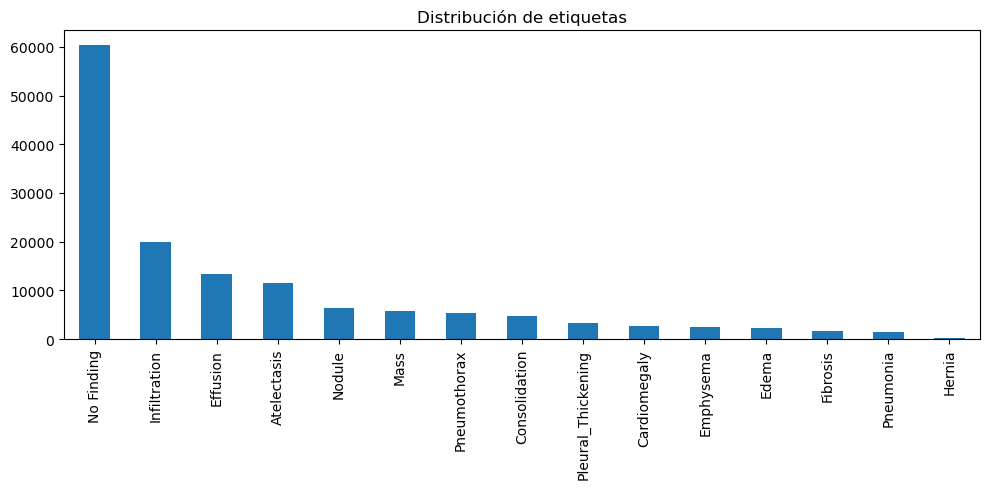

In [11]:
df_filtered[mlb.classes_].sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,5), title='Distribución de etiquetas')
plt.tight_layout()
plt.show()


## 6. Model definition and training

I will build a Convolutional Neural Network (CNN) using TensorFlow/Keras and train it on the preprocessed dataset.


In [12]:
# Usamos solo la primera etiqueta como base para stratify
stratify_labels = df_filtered['Finding Labels'].apply(lambda x: x[0] if len(x) > 0 else 'No Finding')

# Train-test split
train_df, test_df = train_test_split(df_filtered, test_size=0.2, stratify=stratify_labels, random_state=42)

# Stratify también en la validación
stratify_labels_train = train_df['Finding Labels'].apply(lambda x: x[0] if len(x) > 0 else 'No Finding')
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=stratify_labels_train, random_state=42)


In [13]:
# Load CSV and keep only relevant columns
df = pd.read_csv(CSV_PATH)
df = df[['Image Index', 'Finding Labels']]

# Convert multi-labels into lists
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# We take all the classes
df_filtered = df.copy()

df_filtered = df_filtered.copy()  # Make a copy before modifying

df_filtered.loc[:, 'Label'] = df_filtered['Finding Labels'].apply(lambda x: 'Pneumonia' if 'Pneumonia' in x else 'Emphysema')
df_filtered.loc[:, 'filename'] = df_filtered['Image Index'].map(IMAGE_FILES)


# Remove missing files
df_filtered = df_filtered.dropna()

print(f"Images available after filtering: {len(df_filtered)}")
df_filtered.head()


Images available after filtering: 112120


,Image Index,Finding Labels,Label,filename
0,00000001_000.png,[Cardiomegaly],Emphysema,input\images_001/images\00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",Emphysema,input\images_001/images\00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",Emphysema,input\images_001/images\00000001_002.png
3,00000002_000.png,[No Finding],Emphysema,input\images_001/images\00000002_000.png
4,00000003_000.png,[Hernia],Emphysema,input\images_001/images\00000003_000.png


In [14]:
# One-hot encode multi-labels
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(df_filtered['Finding Labels'])

# Agregamos columnas con las clases al dataframe original
labels_df = pd.DataFrame(y_encoded, columns=mlb.classes_)
df_filtered = pd.concat([df_filtered.reset_index(drop=True), labels_df], axis=1)

# → Muy importante: ahora hacemos el split sobre este df completo
stratify_col = df_filtered['Finding Labels'].apply(lambda x: x[0] if len(x) > 0 else 'No Finding')

train_df, test_df = train_test_split(df_filtered, test_size=0.2, stratify=stratify_col, random_state=42)

stratify_val = train_df['Finding Labels'].apply(lambda x: x[0] if len(x) > 0 else 'No Finding')
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=stratify_val, random_state=42)



BATCH_SIZE = 64
IMG_SIZE = (224, 224)

# Image augmentation for training
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
                                   shear_range=0.1, zoom_range=0.1, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from updated file paths
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',  # Full image paths already set in filename column
    y_col=mlb.classes_.tolist(),  # ← etiquetas múltiples
    directory=None,  # No need for a directory since filenames are absolute paths
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',  # ← para multilabel
)

val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename', 
    y_col=mlb.classes_.tolist(),  # ← etiquetas múltiples
    directory=None,  # Same fix
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='raw',  # ← para multilabel
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename', 
    y_col=mlb.classes_.tolist(),  # ← etiquetas múltiples
    directory=None,  # Same fix
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='raw',  # ← para multilabel
    shuffle=False
)



Found 80726 validated image filenames.
Found 8970 validated image filenames.
Found 22424 validated image filenames.


In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)), #lo he cambiado de 224 a 128
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')  # Multi-label output
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=[
                  #'accuracy',
                  AUC(multi_label=True)])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [17]:
EPOCHS = 10  # Start small, increase if necessary

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    #callbacks=[SaveEveryNBatches(100)],
    verbose=1
)


Epoch 1/10
1262/1262 [==============================] - 2636s 2s/step - loss: 0.2181 - auc: 0.5819 - val_loss: 0.2065 - val_auc: 0.6652
Epoch 2/10
1262/1262 [==============================] - 2620s 2s/step - loss: 0.2154 - auc: 0.6012 - val_loss: 0.2035 - val_auc: 0.6746
Epoch 3/10
1262/1262 [==============================] - 2642s 2s/step - loss: 0.2134 - auc: 0.6096 - val_loss: 0.2028 - val_auc: 0.6730
Epoch 4/10
1262/1262 [==============================] - 2631s 2s/step - loss: 0.2123 - auc: 0.6178 - val_loss: 0.2014 - val_auc: 0.6831
Epoch 5/10
1262/1262 [==============================] - 2635s 2s/step - loss: 0.2115 - auc: 0.6209 - val_loss: 0.2017 - val_auc: 0.6876
Epoch 6/10
1262/1262 [==============================] - 2632s 2s/step - loss: 0.2105 - auc: 0.6296 - val_loss: 0.2002 - val_auc: 0.6903
Epoch 7/10
1262/1262 [==============================] - 2597s 2s/step - loss: 0.2098 - auc: 0.6333 - val_loss: 0.2002 - val_auc: 0.6924
Epoch 8/10
1262/1262 [==========================

In [18]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [19]:
#test_loss, test_acc = model.evaluate(test_generator)
#print(f"Test Accuracy: {test_acc:.4f}")


## 7. Model evaluation

Assess the model’s performance on the validation set and visualize relevant metrics.


In [20]:
# AUC durante el entrenamiento
print(history.history['auc'])

# AUC durante la validación
print(history.history['val_auc'])


[0.5819291472434998, 0.6011810302734375, 0.6095569729804993, 0.617827296257019, 0.620894730091095, 0.6296254396438599, 0.6333090662956238, 0.6369665265083313, 0.6426689028739929, 0.644344687461853]
[0.6651718020439148, 0.6745784878730774, 0.673046886920929, 0.6830741763114929, 0.6875818967819214, 0.6903384327888489, 0.692448079586029, 0.6948099732398987, 0.6978330612182617, 0.6968410611152649]


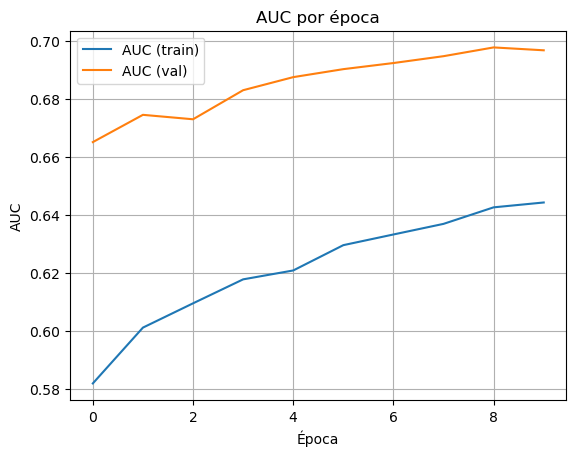

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['auc'], label='AUC (train)')
plt.plot(history.history['val_auc'], label='AUC (val)')
plt.title('AUC por época')
plt.xlabel('Época')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)
plt.show()


2/2 [==============================] - 0s 126ms/step


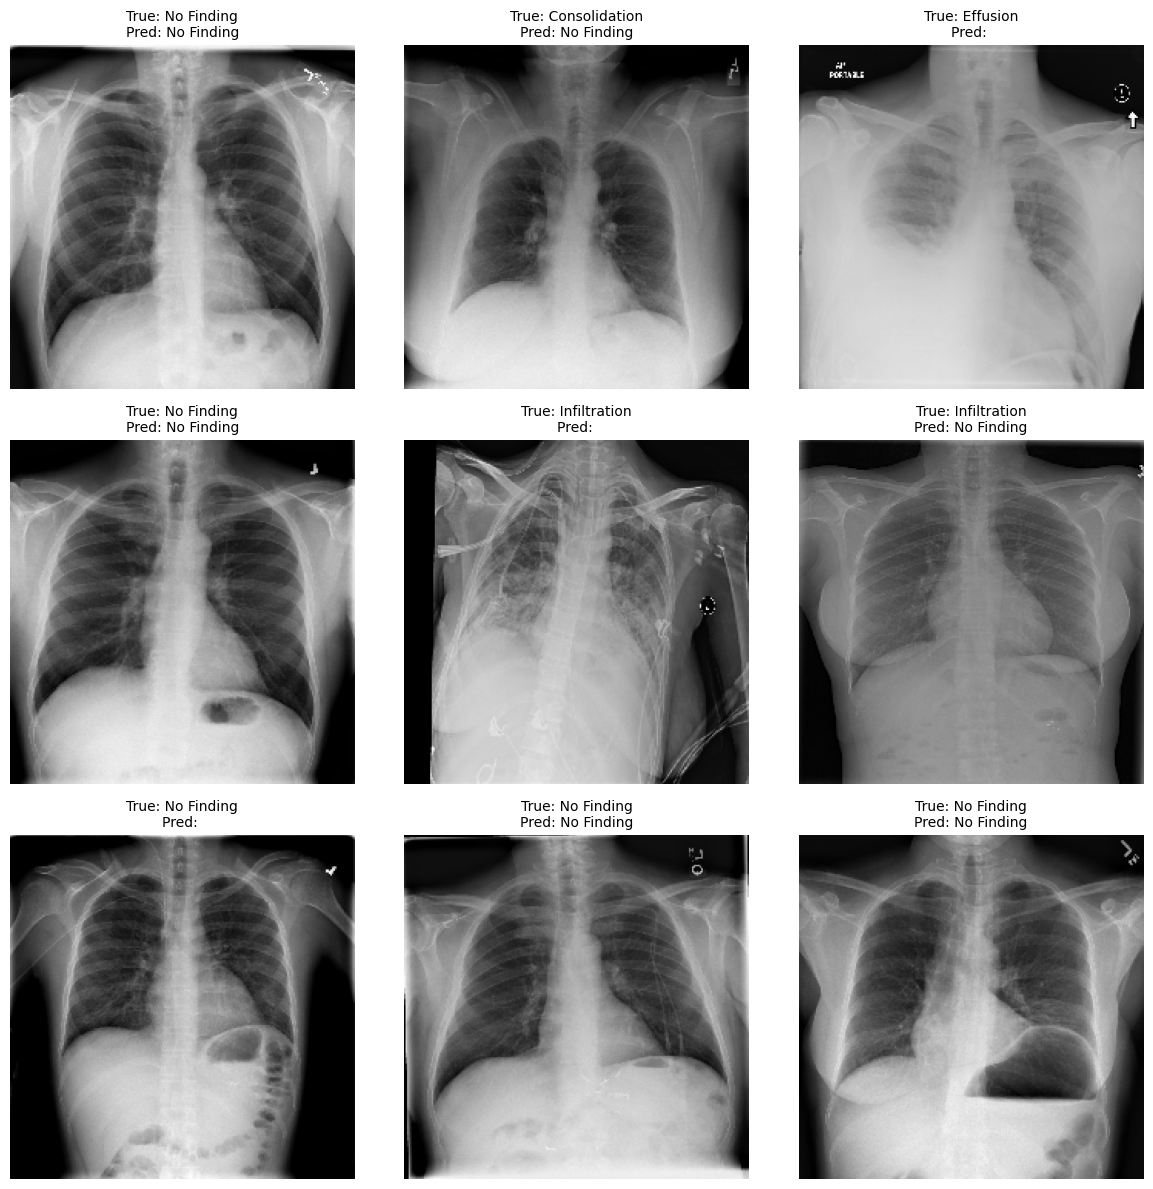

In [22]:
import random

# Obtener un batch del test_generator
sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images)

# Umbral para decir si una clase está presente
threshold = 0.5

# Plot images con predicciones multilabel
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

for i in range(9):
    img = sample_images[i]
    
    # Clases verdaderas y predichas (filtradas por umbral)
    true_classes = [mlb.classes_[j] for j, val in enumerate(sample_labels[i]) if val == 1]
    predicted_classes = [mlb.classes_[j] for j, val in enumerate(predictions[i]) if val >= threshold]
    
    axes[i].imshow(img)
    axes[i].set_title(f"True: {', '.join(true_classes)}\nPred: {', '.join(predicted_classes)}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 9. Conclusion and Observations

The model successfully detects multiple diseases in chest X-ray images using a supervised multilabel learning approach.  
The initial image size (32x32) limited the model’s ability to capture subtle medical details.  
When increasing the resolution to 224x224, a clear improvement in model performance was observed.

The gap between training and validation performance decreased, suggesting that the model is now less constrained by input capacity.  
Still, the model does not show strong signs of overfitting, meaning it could potentially benefit from additional training epochs or a deeper architecture.

The **AUC metric** is appropriate for evaluating multilabel models, especially when classes are imbalanced.  
Overall, the validation vs. training curves show no strong overfitting tendencies, which is a positive outcome.
